
# 01 — EDA: UCI Credit Card Default (PD‑Model)

**Цель:** системно изучить данные, проверить качество, понять распределения и взаимосвязи, выявить риски утечек и подготовить список гипотез для признаков и моделей.

**Датасет:** *Default of Credit Card Clients Dataset (Taiwan)*  
**Целевая переменная:** `target` (бывш. `default.payment.next.month`) — 1 = дефолт в следующем месяце, 0 = нет.



## Содержание
1. [Настройки и загрузка параметров](#setup)
2. [Загрузка данных и проверка схемы](#load)
3. [Быстрый обзор: размеры, типы, пропуски](#quick)
4. [Баланс классов и baseline](#target)
5. [Категориальные признаки: `sex`, `education`, `marriage`](#cats)
6. [Платежная дисциплина: `pay_0`, ..., `pay_6`](#pay)
7. [Счета и платежи: `bill_amt*`, `pay_amt*`](#bills)
8. [Корреляции (Pearson/Spearman), heatmap](#corr)
9. [Выбросы и лог‑шкала](#outliers)
10. [Предпросмотр безопасных производных признаков (без утечки)](#preview)
11. [Риски, замечания и следующий шаг](#next)


## 1. Настройки и загрузка параметров <a id='setup'></a>

In [1]:
# Базовые импорты
import os, json, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
warnings.filterwarnings("ignore")

# Графики
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# --- НАДЁЖНЫЙ ПОИСК params.yaml И УСТАНОВКА КОРНЯ ПРОЕКТА ---
# Ищем params.yaml в текущей папке или выше (до 3 уровней)
def find_params(start: Path = Path.cwd(), max_up: int = 3) -> Path:
    p = start
    for _ in range(max_up + 1):
        cand = p / "params.yaml"
        if cand.exists():
            return cand
        p = p.parent
    raise FileNotFoundError("params.yaml not found (looked up 3 parents). "
                            "Run notebook from project root or notebooks/.")

PARAMS_PATH = find_params(Path.cwd())
PROJECT_ROOT = PARAMS_PATH.parent
os.chdir(PROJECT_ROOT)  # гарантируем, что пути дальше относительны корня проекта

print(f"[EDA] Using project root: {PROJECT_ROOT}")

# Загружаем параметры проекта
import yaml
with open(PARAMS_PATH, "r") as f:
    P = yaml.safe_load(f)

RAW_PATH = P["data"]["raw_path"]
TARGET_COL = P["data"]["target"]  # ожидается 'target' после приведения колонок

# Страхуемся: показываем, что файл существует
assert Path(RAW_PATH).exists(), f"RAW_PATH not found: {RAW_PATH}"
print(f"[EDA] RAW_PATH: {RAW_PATH}")


[EDA] Using project root: /Users/alext/Desktop/MIFI 3/Трек_2_Автоматизация_процессов_разработки_и_тестирования_моделей_машинного_обучения_Сессионное_задание_Итоговый_проект/Alexander_Tarakanov_Track_1_Final_Project
[EDA] RAW_PATH: data/raw/UCI_Credit_Card.csv


## 2. Загрузка данных и проверка схемы <a id='load'></a>

In [2]:
# Читаем сырые данные
from pathlib import Path

print(f"[EDA] Checking raw file exists: {RAW_PATH}")
assert Path(RAW_PATH).exists(), f"❌ RAW data not found at {RAW_PATH}. Run `dvc pull` first."

raw = pd.read_csv(RAW_PATH)
print("✅ Raw data loaded successfully")
print("Raw shape:", raw.shape)

# Просмотр первых строк
display(raw.head())


[EDA] Checking raw file exists: data/raw/UCI_Credit_Card.csv
✅ Raw data loaded successfully
Raw shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
# Стандартизируем имена колонок
df = raw.copy()
df.columns = df.columns.str.lower().str.replace(".", "_", regex=False)

print("[EDA] Columns normalized. Sample:", df.columns[:10])

# ✅ Обработка целевой колонки
if "default_payment_next_month" in df.columns and TARGET_COL not in df.columns:
    df = df.rename(columns={"default_payment_next_month": TARGET_COL})
elif TARGET_COL not in df.columns:
    raise ValueError(f"❌ Target column '{TARGET_COL}' not found in raw data!")

# ✅ Приведение PAY_* (если вместо pay_0 есть pay_1)
if "pay_1" in df.columns and "pay_0" not in df.columns:
    print("[EDA] Renaming pay_1 → pay_0")
    df = df.rename(columns={"pay_1": "pay_0"})

# ✅ Удаление ID, если есть
if "id" in df.columns:
    df = df.drop(columns=["id"])

# ✅ Проверка колонок
base_cols = [
    "limit_bal", "sex", "education", "marriage", "age",
    "pay_0", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6",
    "bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6",
    "pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6",
    TARGET_COL,
]

missing = [c for c in base_cols if c not in df.columns]
extra = [c for c in df.columns if c not in base_cols]

print("Missing columns:", missing)
print("Extra columns:", extra)

# ✅ Жёсткая защита: если данных нет → Stop
if missing:
    raise ValueError("❌ Dataset schema mismatch! Expected columns missing: " + ", ".join(missing))

print("✅ Schema OK. Proceeding with cleaned dataframe.")
df.head()


[EDA] Columns normalized. Sample: Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4'], dtype='object')
Missing columns: []
Extra columns: []
✅ Schema OK. Proceeding with cleaned dataframe.


,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## 3. Быстрый обзор: размеры, типы, пропуски <a id='quick'></a>

In [4]:
# ===============================
# 3️⃣ Быстрый обзор данных
# ===============================

print("✅ Data loaded. First rows:")
display(df.head(5))

print("\n📊 Описание числовых признаков:")
display(df.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T)

print("\n🔤 Типы данных:")
print(df.dtypes)

# ---- Пропуски ----
print("\n🔍 Пропуски по столбцам:")

na = df.isna().sum().sort_values(ascending=False)
na_nonzero = na[na > 0]

if len(na_nonzero) == 0:
    print("✅ Нет пропусков в данных.")
else:
    display(pd.DataFrame({
        "missing_count": na_nonzero,
        "missing_percent": (na_nonzero / len(df) * 100).round(3)
    }))

# ---- Строгий контроль ключевых колонок ----
must_have_no_nulls = [
    "sex", "education", "marriage", "age",
    "pay_0", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6",
    TARGET_COL
]

wrong_nulls = [c for c in must_have_no_nulls if df[c].isna().any()]
if wrong_nulls:
    print("❌ ОБНАРУЖЕНЫ НЕДОПУСТИМЫЕ NaN:", wrong_nulls)
    display(df[wrong_nulls].isna().sum())
else:
    print("✅ Ключевые признаки и целевая колонка не содержат NaN")

# ---- Проверка целевой ----
assert df[TARGET_COL].isin([0, 1]).all(), "❌ Некорректные значения в target!"

print("\n✅ Быстрый обзор завершён.")


✅ Data loaded. First rows:


,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0



📊 Описание числовых признаков:


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
limit_bal,30000.0,167484.322667,129747.661567,10000.0,10000.00,20000.0,50000.00,140000.0,240000.00,430000.00,500000.00,1000000.0
sex,30000.0,1.603733,0.489129,1.0,1.00,1.0,1.00,2.0,2.00,2.00,2.00,2.0
education,30000.0,1.853133,0.790349,0.0,1.00,1.0,1.00,2.0,2.00,3.00,5.00,6.0
marriage,30000.0,1.551867,0.521970,0.0,1.00,1.0,1.00,2.0,2.00,2.00,3.00,3.0
age,30000.0,35.485500,9.217904,21.0,22.00,23.0,28.00,34.0,41.00,53.00,60.00,79.0
pay_0,30000.0,-0.016700,1.123802,-2.0,-2.00,-2.0,-1.00,0.0,0.00,2.00,3.00,8.0
pay_2,30000.0,-0.133767,1.197186,-2.0,-2.00,-2.0,-1.00,0.0,0.00,2.00,3.00,8.0
pay_3,30000.0,-0.166200,1.196868,-2.0,-2.00,-2.0,-1.00,0.0,0.00,2.00,3.00,8.0
pay_4,30000.0,-0.220667,1.169139,-2.0,-2.00,-2.0,-1.00,0.0,0.00,2.00,3.00,8.0
pay_5,30000.0,-0.266200,1.133187,-2.0,-2.00,-2.0,-1.00,0.0,0.00,2.00,3.00,8.0



🔤 Типы данных:
limit_bal    float64
sex            int64
education      int64
marriage       int64
age            int64
pay_0          int64
pay_2          int64
pay_3          int64
pay_4          int64
pay_5          int64
pay_6          int64
bill_amt1    float64
bill_amt2    float64
bill_amt3    float64
bill_amt4    float64
bill_amt5    float64
bill_amt6    float64
pay_amt1     float64
pay_amt2     float64
pay_amt3     float64
pay_amt4     float64
pay_amt5     float64
pay_amt6     float64
target         int64
dtype: object

🔍 Пропуски по столбцам:
✅ Нет пропусков в данных.
✅ Ключевые признаки и целевая колонка не содержат NaN

✅ Быстрый обзор завершён.


## 4. Баланс классов и baseline <a id='target'></a>

,class,count,proportion
0,0,23364,0.7788
1,1,6636,0.2212


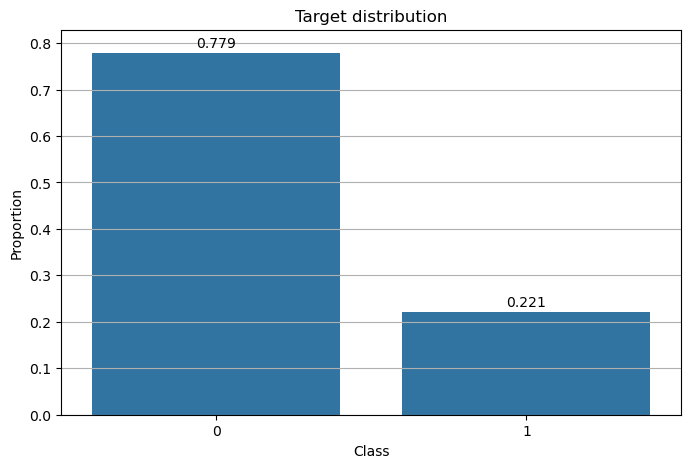

Baseline accuracy (always majority class): 0.7788
Imbalance ratio (majority/minority): 3.52x
⚠️ Сильный дисбаланс: рассмотрите class_weight, пороговую настройку или resampling.


In [5]:
# ===============================
# 4️⃣ Баланс классов и baseline
# ===============================

# Счёты и доли
vc = df[TARGET_COL].value_counts().sort_index()
prop = df[TARGET_COL].value_counts(normalize=True).sort_index()

# Гарантируем наличие обоих классов в отображении
classes = [0, 1]
cnt = [int(vc.get(c, 0)) for c in classes]
prt = [float(prop.get(c, 0.0)) for c in classes]

# Таблица-резюме
summary = pd.DataFrame({
    "class": classes,
    "count": cnt,
    "proportion": np.round(prt, 4),
})
display(summary)

# Визуализация
fig, ax = plt.subplots()
sns.barplot(x=summary["class"], y=summary["proportion"], ax=ax)
ax.set_title("Target distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Proportion")
# подписи над барами
for i, v in enumerate(summary["proportion"].values):
    ax.text(i, v + 0.005, f"{v:.3f}", ha="center", va="bottom")
plt.ylim(0, max(summary["proportion"].max() + 0.05, 0.2))
plt.show()

# Бейзлайн: угадывать всегда majority класс
baseline = max(prt) if any(prt) else 0.0
print(f"Baseline accuracy (always majority class): {baseline:.4f}")

# Метрика дисбаланса (отношение классов 0/1, если оба есть)
if cnt[0] > 0 and cnt[1] > 0:
    imbalance_ratio = max(cnt[0], cnt[1]) / min(cnt[0], cnt[1])
    print(f"Imbalance ratio (majority/minority): {imbalance_ratio:.2f}x")
    if imbalance_ratio >= 3:
        print("⚠️ Сильный дисбаланс: рассмотрите class_weight, пороговую настройку или resampling.")
else:
    print("⚠️ В данных присутствует только один класс — метрики вроде ROC-AUC будут некорректны.")


## 5. Категориальные признаки <a id='cats'></a>


📌 Feature: sex


,count,proportion,default_rate
sex,,,
1,11888,0.3963,0.2417
2,18112,0.6037,0.2078


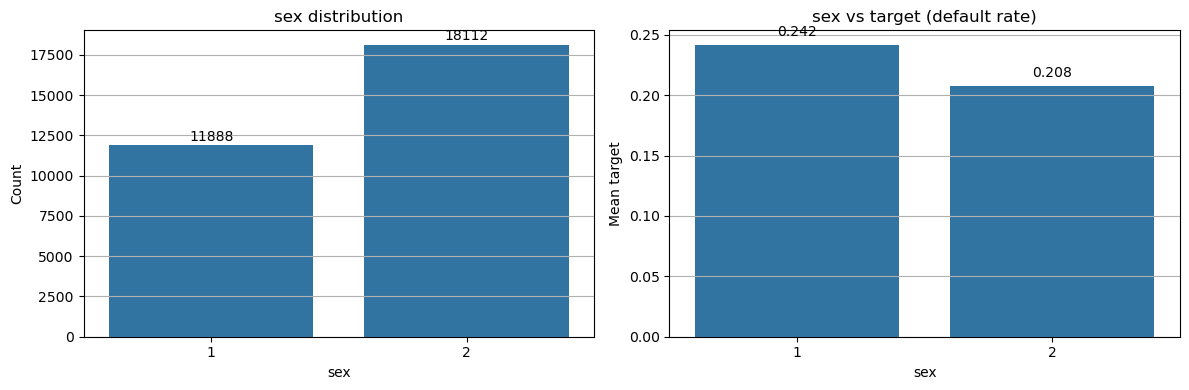


📌 Feature: education


,count,proportion,default_rate
education,,,
0,14,0.0005,0.0000
1,10585,0.3528,0.1923
2,14030,0.4677,0.2373
3,4917,0.1639,0.2516
4,123,0.0041,0.0569
5,280,0.0093,0.0643
6,51,0.0017,0.1569


⚠️ Anomalies in education: unexpected category codes detected!


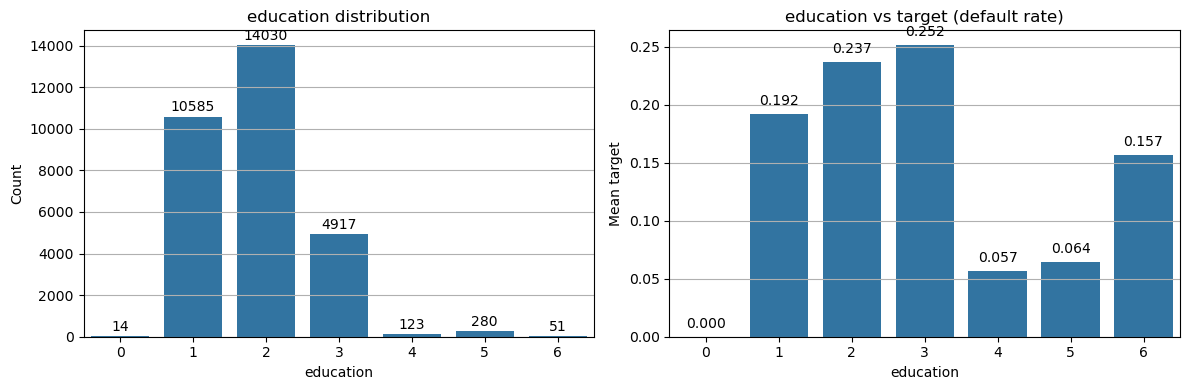


📌 Feature: marriage


,count,proportion,default_rate
marriage,,,
0,54,0.0018,0.0926
1,13659,0.4553,0.2347
2,15964,0.5321,0.2093
3,323,0.0108,0.2601


⚠️ Anomalies in marriage: unexpected category codes detected!


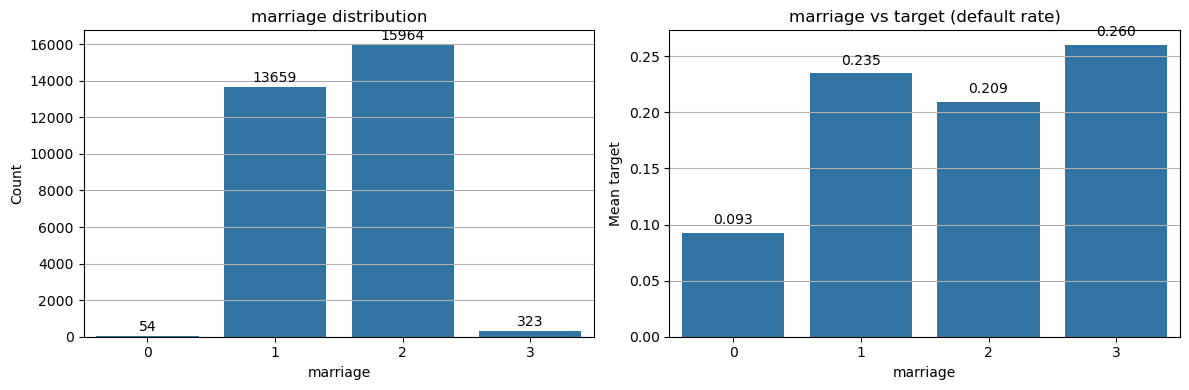

In [6]:
# ===============================
# 5️⃣ Категориальные признаки
# ===============================

cats = ["sex", "education", "marriage"]

for c in cats:
    if c not in df.columns:
        print(f"⚠️ {c} отсутствует в данных — пропускаем.")
        continue

    print(f"\n📌 Feature: {c}")

    # Частоты
    vc = df[c].value_counts(dropna=False).sort_index()
    pr = df[c].value_counts(normalize=True, dropna=False).sort_index()

    summary = pd.DataFrame({
        "count": vc,
        "proportion": pr.round(4),
        "default_rate": df.groupby(c)[TARGET_COL].mean().round(4)
    })

    display(summary)

    # Поиск аномальных значений
    if summary.index.min() < 1 or summary.index.max() > 4:
        print(f"⚠️ Anomalies in {c}: unexpected category codes detected!")

    # --- Visualization ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Countplot
    sns.countplot(data=df, x=c, ax=ax[0], order=summary.index)
    ax[0].set_title(f"{c} distribution")
    ax[0].set_ylabel("Count")
    # подписи над баром
    for i, (idx, row) in enumerate(summary.iterrows()):
        ax[0].text(i, row["count"] + 100, str(int(row["count"])),
                   ha="center", va="bottom", fontsize=10)

    # Default rate plot
    sns.barplot(x=summary.index, y=summary["default_rate"], ax=ax[1])
    ax[1].set_title(f"{c} vs target (default rate)")
    ax[1].set_ylabel("Mean target")
    # подписи
    for i, v in enumerate(summary["default_rate"]):
        ax[1].text(i, v + 0.005, f"{v:.3f}", 
                   ha="center", va="bottom", fontsize=10)

    plt.tight_layout()
    plt.show()


## 6. Платежная дисциплина: PAY_0…PAY_6 <a id='pay'></a>

PAY columns: ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

📊 Basic stats:


,count,mean,std,min,25%,50%,75%,max
pay_0,30000.0,-0.016700,1.123802,-2.0,-1.0,0.0,0.0,8.0
pay_2,30000.0,-0.133767,1.197186,-2.0,-1.0,0.0,0.0,8.0
pay_3,30000.0,-0.166200,1.196868,-2.0,-1.0,0.0,0.0,8.0
pay_4,30000.0,-0.220667,1.169139,-2.0,-1.0,0.0,0.0,8.0
pay_5,30000.0,-0.266200,1.133187,-2.0,-1.0,0.0,0.0,8.0
pay_6,30000.0,-0.291100,1.149988,-2.0,-1.0,0.0,0.0,8.0



📌 Feature: pay_0


,count,prop,default_rate
pay_0,,,
-2,2759,0.0920,0.1323
-1,5686,0.1895,0.1678
0,14737,0.4912,0.1281
1,3688,0.1229,0.3395
2,2667,0.0889,0.6914
3,322,0.0107,0.7578
4,76,0.0025,0.6842
5,26,0.0009,0.5000
6,11,0.0004,0.5455


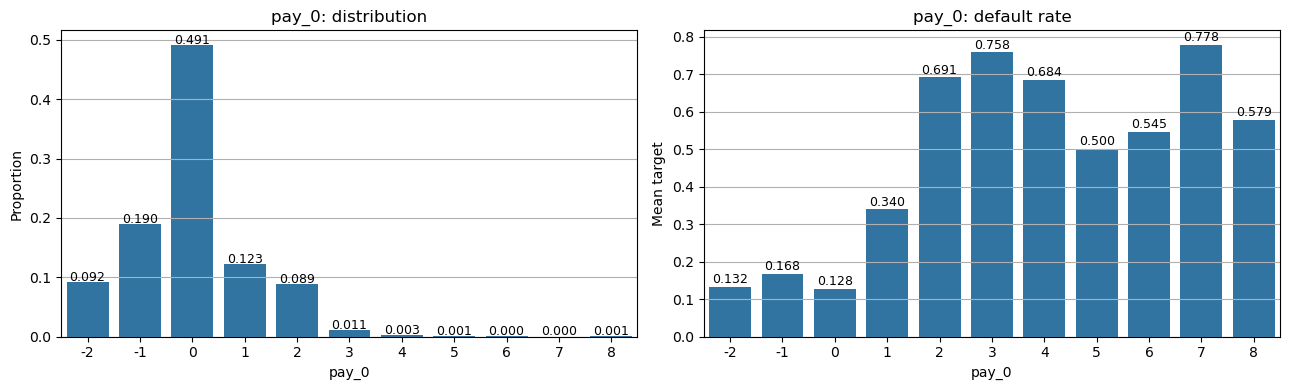


📌 Feature: pay_2


,count,prop,default_rate
pay_2,,,
-2,3782,0.1261,0.1827
-1,6050,0.2017,0.1597
0,15730,0.5243,0.1591
1,28,0.0009,0.1786
2,3927,0.1309,0.5561
3,326,0.0109,0.6166
4,99,0.0033,0.5051
5,25,0.0008,0.6000
6,12,0.0004,0.7500


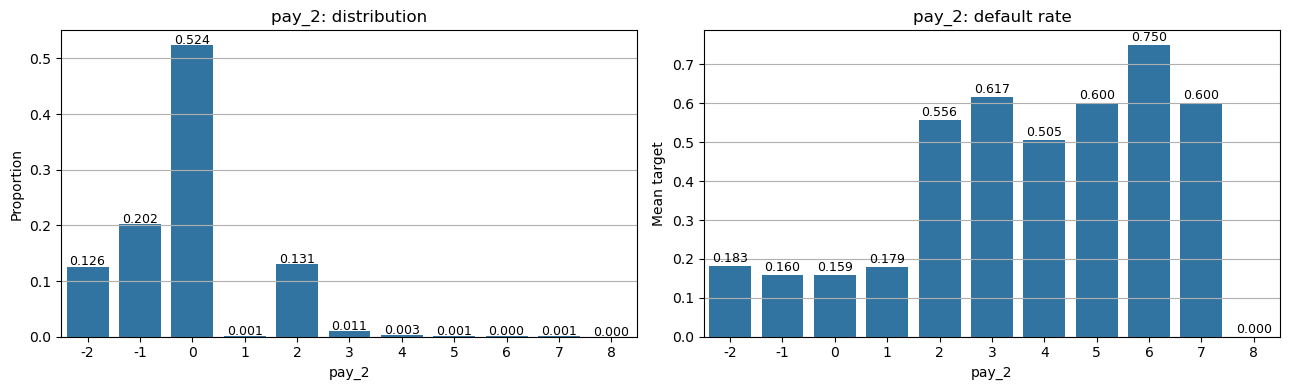


📌 Feature: pay_3


,count,prop,default_rate
pay_3,,,
-2,4085,0.1362,0.1853
-1,5938,0.1979,0.1559
0,15764,0.5255,0.1745
1,4,0.0001,0.2500
2,3819,0.1273,0.5156
3,240,0.0080,0.5750
4,76,0.0025,0.5789
5,21,0.0007,0.5714
6,23,0.0008,0.6087


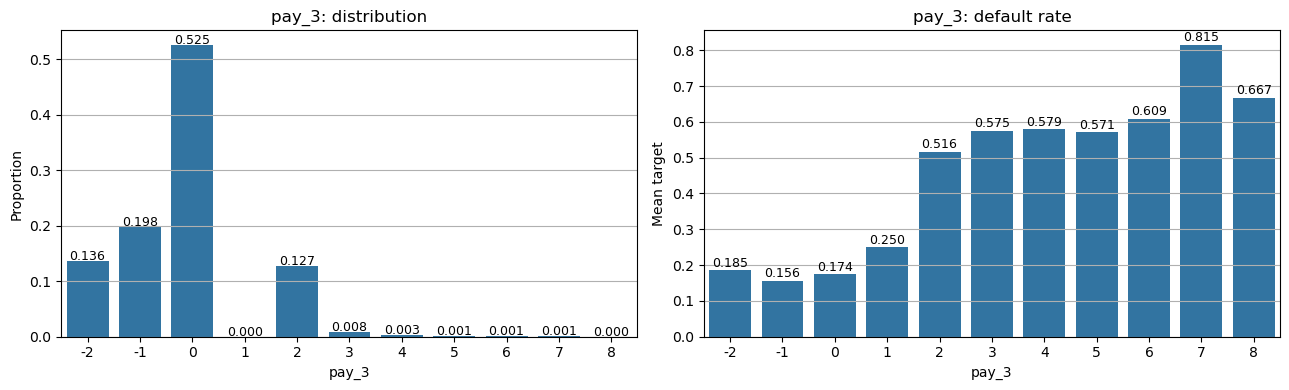


📌 Feature: pay_4


,count,prop,default_rate
pay_4,,,
-2,4348,0.1449,0.1925
-1,5687,0.1896,0.1590
0,16455,0.5485,0.1833
1,2,0.0001,0.5000
2,3159,0.1053,0.5233
3,180,0.0060,0.6111
4,69,0.0023,0.6667
5,35,0.0012,0.5143
6,5,0.0002,0.4000


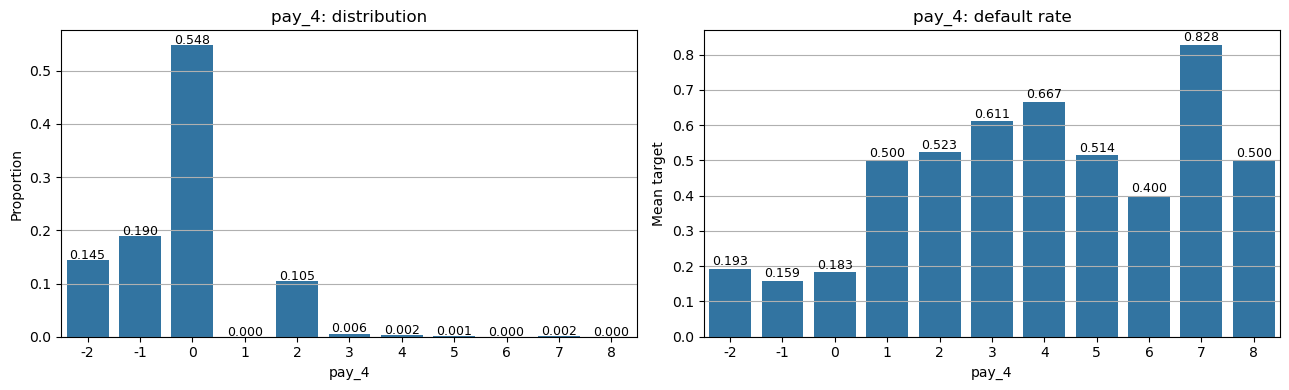


📌 Feature: pay_5


,count,prop,default_rate
pay_5,,,
-2,4546,0.1515,0.1969
-1,5539,0.1846,0.1619
0,16947,0.5649,0.1885
2,2626,0.0875,0.5419
3,178,0.0059,0.6348
4,84,0.0028,0.6071
5,17,0.0006,0.5882
6,4,0.0001,0.7500
7,58,0.0019,0.8276


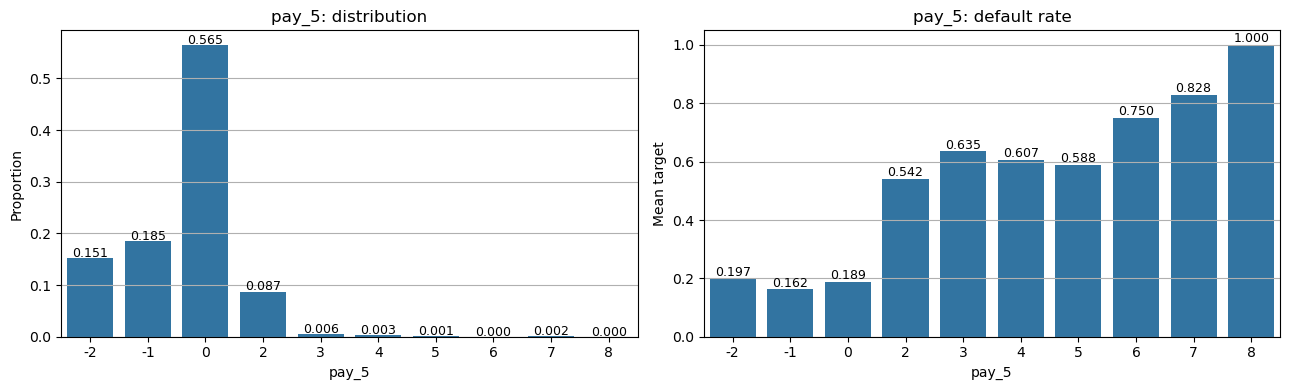


📌 Feature: pay_6


,count,prop,default_rate
pay_6,,,
-2,4895,0.1632,0.2004
-1,5740,0.1913,0.1699
0,16286,0.5429,0.1884
2,2766,0.0922,0.5065
3,184,0.0061,0.6413
4,49,0.0016,0.6327
5,13,0.0004,0.5385
6,19,0.0006,0.7368
7,46,0.0015,0.8261


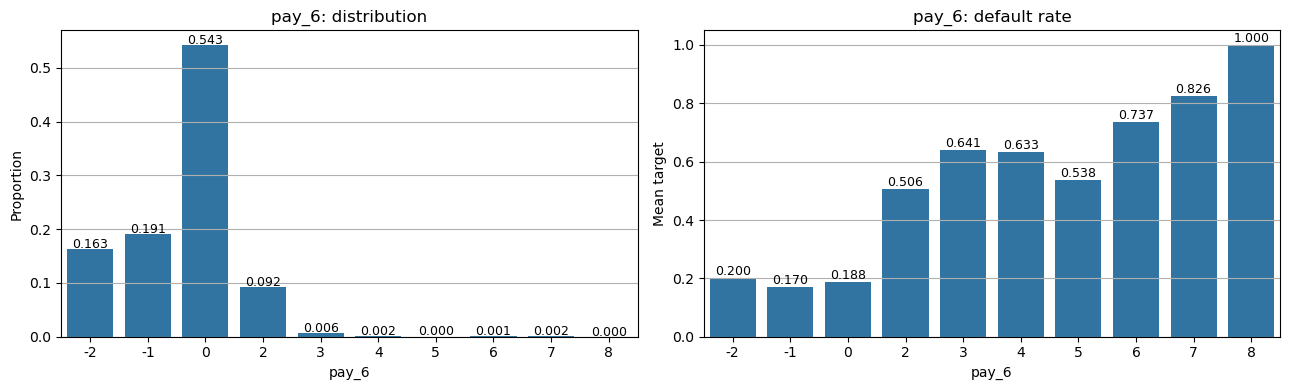

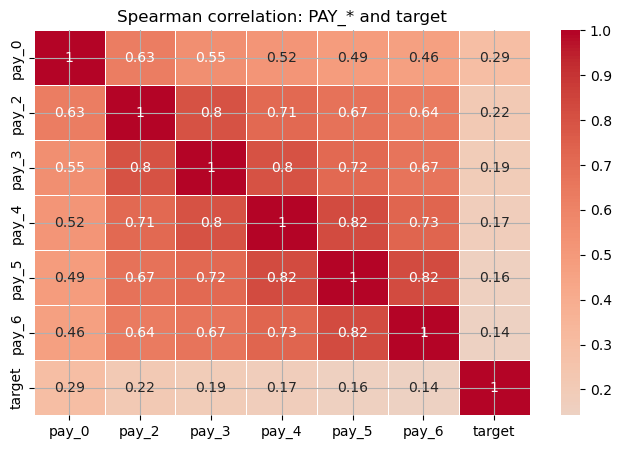

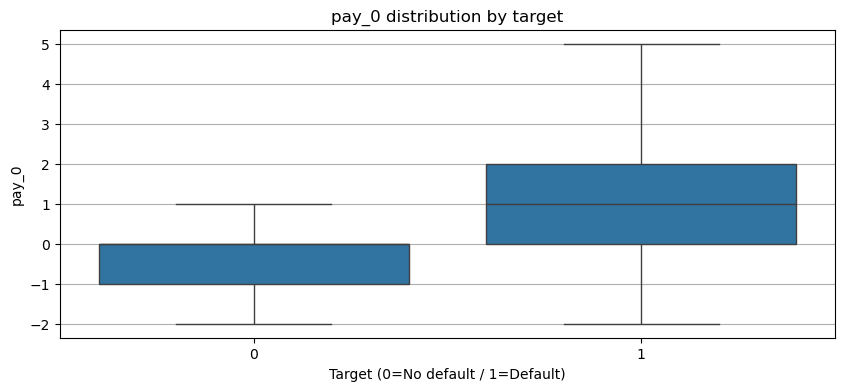

In [7]:
# ===============================
# 6️⃣ Платежная дисциплина PAY_0…PAY_6
# ===============================

pay_cols = [c for c in ["pay_0", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6"] if c in df.columns]
print("PAY columns:", pay_cols)

# Общая статистика
print("\n📊 Basic stats:")
display(df[pay_cols].describe().T)

# Частоты значений и условная вероятность дефолта
for c in pay_cols:
    print(f"\n📌 Feature: {c}")
    vc = df[c].value_counts(dropna=False).sort_index()
    pr = df[c].value_counts(normalize=True, dropna=False).sort_index()
    tmean = df.groupby(c)[TARGET_COL].mean().round(4)

    stat = pd.DataFrame({
        "count": vc,
        "prop": pr.round(4),
        "default_rate": tmean
    })
    display(stat)

    # Быстрый визуал распределения
    fig, ax = plt.subplots(1, 2, figsize=(13, 4))
    sns.barplot(x=stat.index, y=stat["prop"], ax=ax[0])
    ax[0].set_title(f"{c}: distribution")
    ax[0].set_ylabel("Proportion")
    for i, v in enumerate(stat["prop"]):
        ax[0].text(i, v + 0.002, f"{v:.3f}", ha="center", fontsize=9)

    sns.barplot(x=stat.index, y=stat["default_rate"], ax=ax[1])
    ax[1].set_title(f"{c}: default rate")
    ax[1].set_ylabel("Mean target")
    for i, v in enumerate(stat["default_rate"]):
        ax[1].text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=9)

    plt.tight_layout()
    plt.show()

# Heatmap: связь просрочек по всем месяцам с target
corr_df = df[pay_cols + [TARGET_COL]].corr(method="spearman")
plt.figure(figsize=(8, 5))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", center=0, linewidths=.5)
plt.title("Spearman correlation: PAY_* and target")
plt.show()

# Boxplot: default vs non-default по PAY_*
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df, x=TARGET_COL, y="pay_0", showfliers=False)
ax.set_title("pay_0 distribution by target")
ax.set_xlabel("Target (0=No default / 1=Default)")
plt.show()



## 7. Счета и платежи: bill_amt*, pay_amt* <a id='bills'></a>

Bill amount features: ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']
Payment amount features: ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
bill_amt1,30000.0,51223.330900,73635.860576,-165580.0,-81.00,278.9,3558.75,22381.5,67091.00,142133.7,350110.68,964511.0
bill_amt2,30000.0,49179.075167,71173.768783,-69777.0,-200.00,0.0,2984.75,21200.0,64006.25,136905.5,337495.28,983931.0
bill_amt3,30000.0,47013.154800,69349.387427,-157264.0,-200.00,0.0,2666.25,20088.5,60164.75,132051.3,325030.39,1664089.0
bill_amt4,30000.0,43262.948967,64332.856134,-170000.0,-212.02,0.0,2326.75,19052.0,54506.00,122418.7,304997.27,891586.0
bill_amt5,30000.0,40311.400967,60797.155770,-81334.0,-232.01,0.0,1763.00,18104.5,50190.50,115883.0,285868.33,927171.0
bill_amt6,30000.0,38871.760400,59554.107537,-339603.0,-331.03,0.0,1256.00,17071.0,49198.25,112110.4,279505.06,961664.0
pay_amt1,30000.0,5663.580500,16563.280354,0.0,0.00,0.0,1000.00,2100.0,5006.00,10300.0,66522.18,873552.0
pay_amt2,30000.0,5921.163500,23040.870402,0.0,0.00,0.0,833.00,2009.0,5000.00,10401.1,76651.02,1684259.0
pay_amt3,30000.0,5225.681500,17606.961470,0.0,0.00,0.0,390.00,1800.0,4505.00,10000.0,70000.00,896040.0
pay_amt4,30000.0,4826.076867,15666.159744,0.0,0.00,0.0,296.00,1500.0,4013.25,9570.6,67054.44,621000.0



🚨 Negative bill amounts per feature:


bill_amt1    590
bill_amt2    669
bill_amt3    655
bill_amt4    675
bill_amt5    655
bill_amt6    688
dtype: int64


🚨 Negative payment amounts per feature:


Series([], dtype: int64)


📊 Корреляции bill_amt* с target (Spearman):


bill_amt6   -0.0054
bill_amt5   -0.0068
bill_amt4   -0.0102
bill_amt3   -0.0141
bill_amt2   -0.0142
bill_amt1   -0.0196
Name: target, dtype: float64

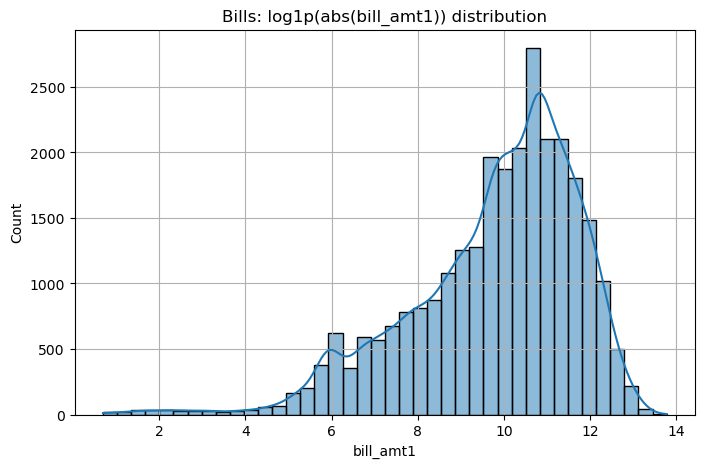

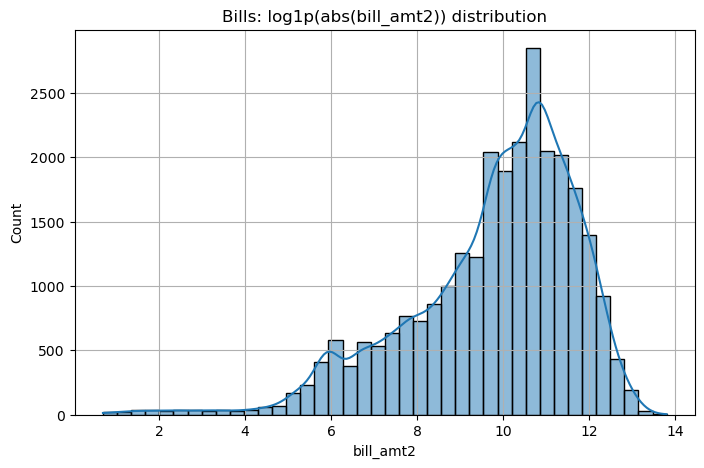

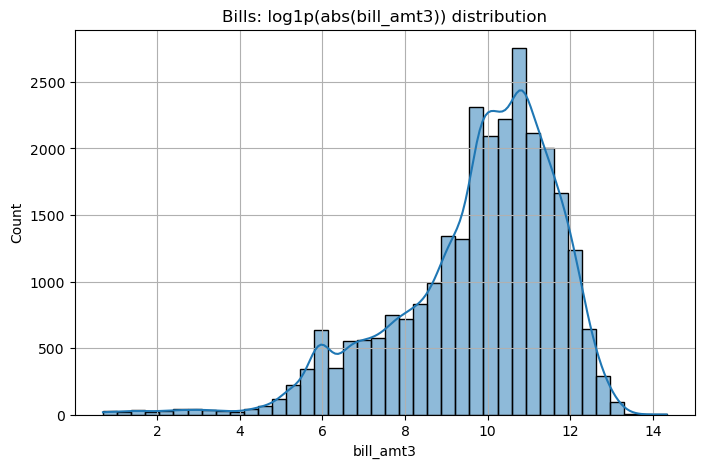

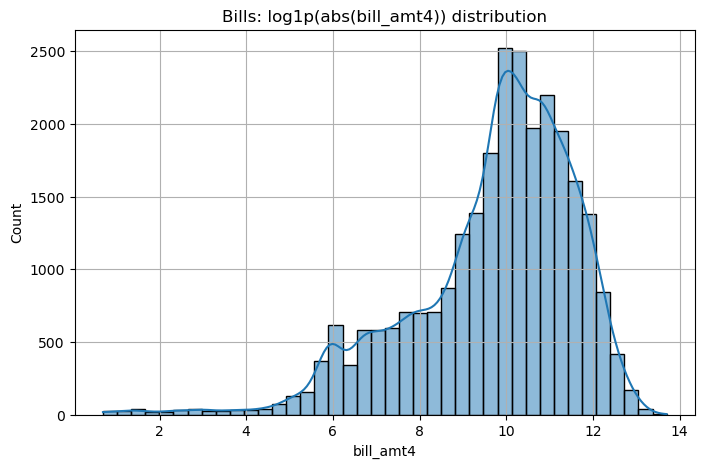

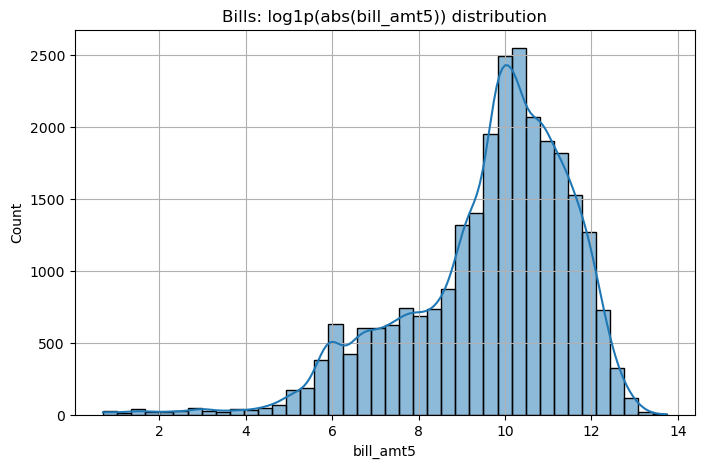

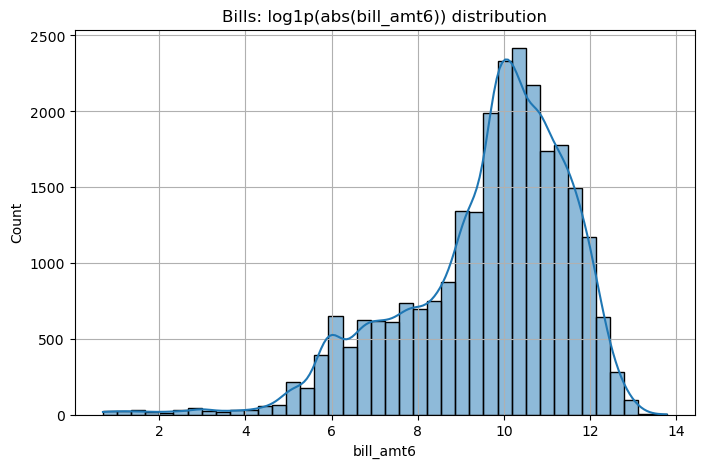

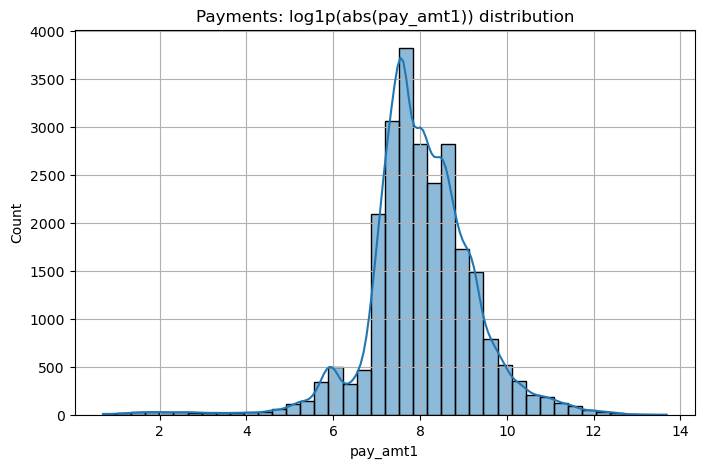

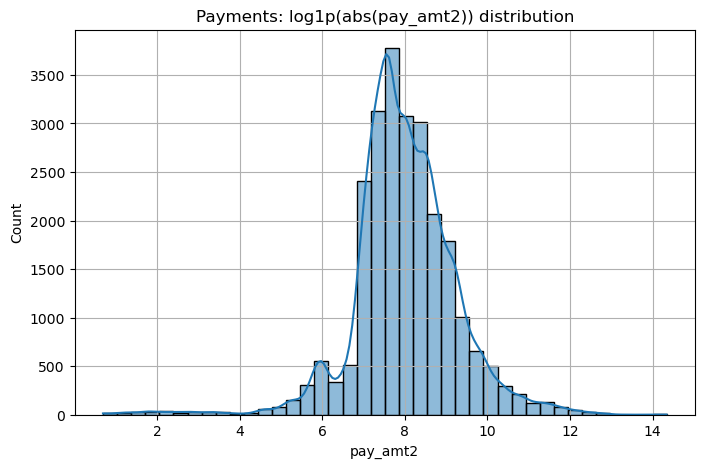

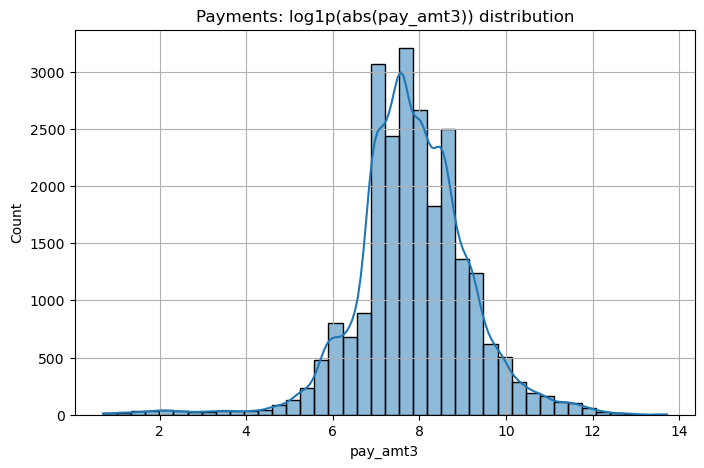

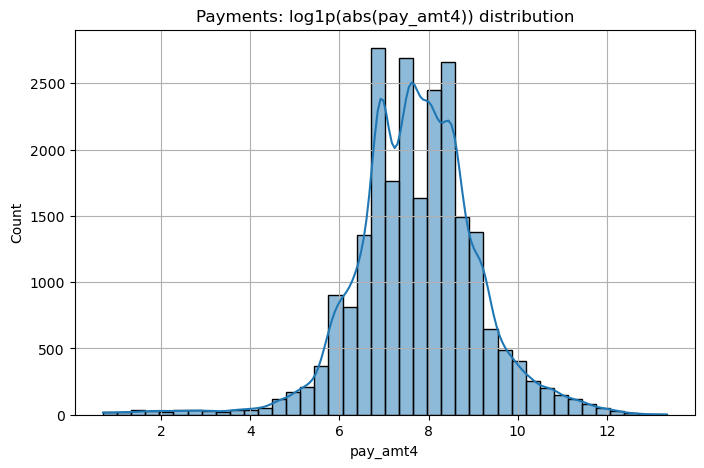

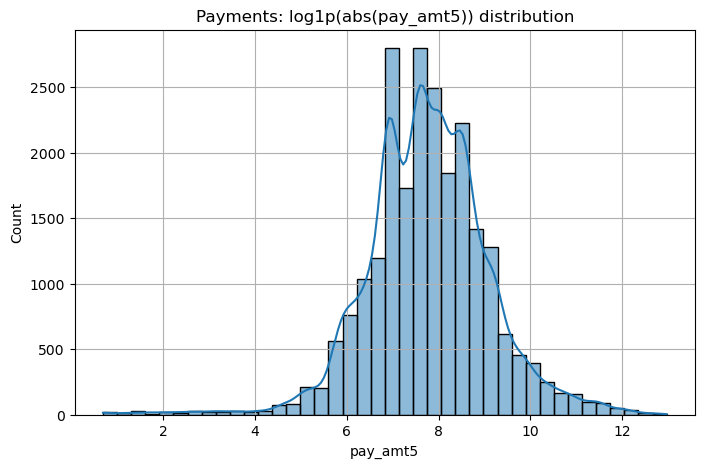

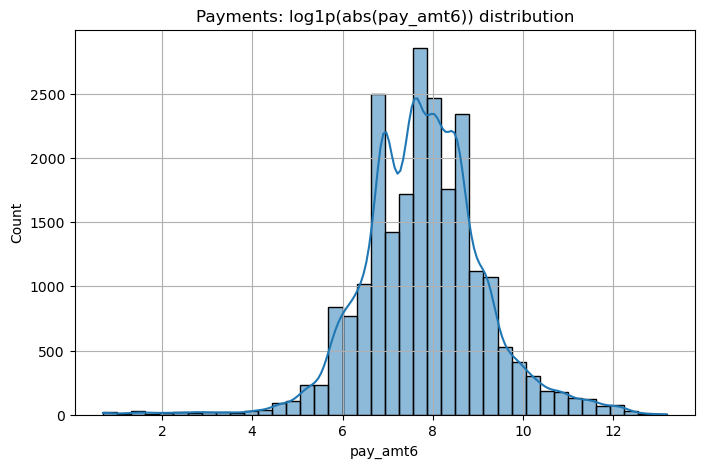

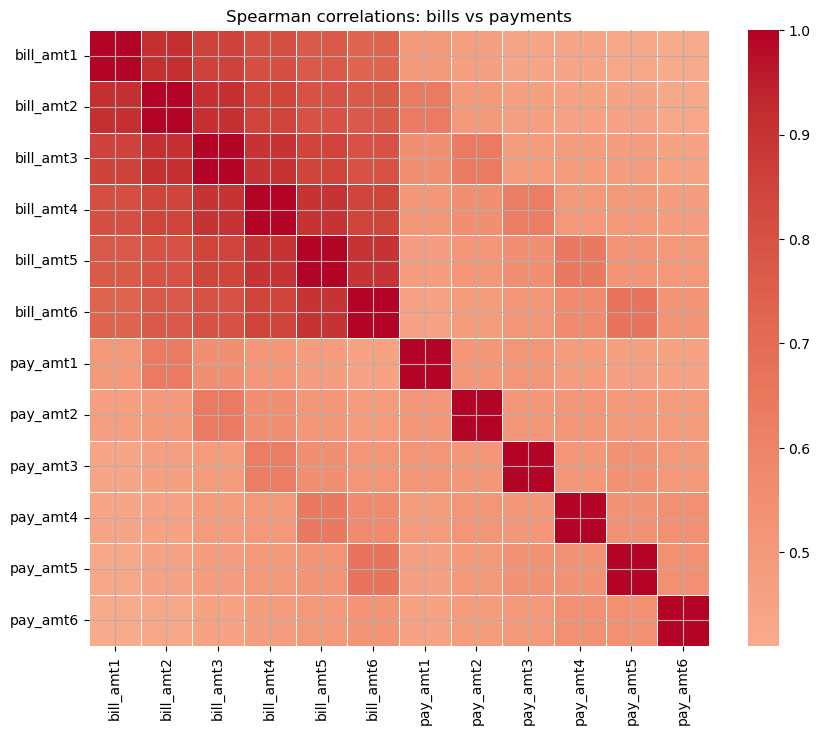


✅ Bills & payments analysis completed.


In [8]:
# ===============================
# 7️⃣ Счета (bill_amt*) и платежи (pay_amt*)
# ===============================

bill_cols = [f"bill_amt{i}" for i in range(1,7) if f"bill_amt{i}" in df.columns]
pay_amt_cols = [f"pay_amt{i}" for i in range(1,7) if f"pay_amt{i}" in df.columns]

print("Bill amount features:", bill_cols)
print("Payment amount features:", pay_amt_cols)

# ---- Базовая статистика ----
display(df[bill_cols + pay_amt_cols].describe(percentiles=[.01,.1,.25,.5,.75,.9,.99]).T)

# ---- Проверка на отрицательные значения (аномалии) ----
neg_bills = (df[bill_cols] < 0).sum()
neg_pays = (df[pay_amt_cols] < 0).sum()

print("\n🚨 Negative bill amounts per feature:")
display(neg_bills[neg_bills > 0])

print("\n🚨 Negative payment amounts per feature:")
display(neg_pays[neg_pays > 0])

# ---- Корреляции bill vs target ----
bill_target_corr = df[bill_cols + [TARGET_COL]].corr()[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)
print("\n📊 Корреляции bill_amt* с target (Spearman):")
display(bill_target_corr.round(4))

# ---- Лог-гистограммы счетов ----
for grp, cols in {"Bills": bill_cols, "Payments": pay_amt_cols}.items():
    for c in cols:
        vals = df[c].replace(0, np.nan)
        fig, ax = plt.subplots()
        sns.histplot(np.log1p(vals.dropna().abs()), bins=40, ax=ax, kde=True)
        ax.set_title(f"{grp}: log1p(abs({c})) distribution")
        plt.show()

# ---- Heatmap bill_amt* vs pay_amt* (взаимосвязи) ----
full_corr = df[bill_cols + pay_amt_cols].corr(method="spearman")
plt.figure(figsize=(10, 8))
sns.heatmap(full_corr, cmap="coolwarm", center=0, linewidths=.5)
plt.title("Spearman correlations: bills vs payments")
plt.show()

print("\n✅ Bills & payments analysis completed.")


## 8. Корреляции (Pearson/Spearman), heatmap <a id='corr'></a>

📌 Top-15 признаков по связи с target (Spearman rho):


,corr_abs
pay_0,0.292213
pay_2,0.216919
pay_3,0.194771
pay_4,0.173690
limit_bal,0.169586
pay_amt1,0.160493
pay_5,0.159043
pay_amt2,0.150977
pay_6,0.142523
pay_amt3,0.139388


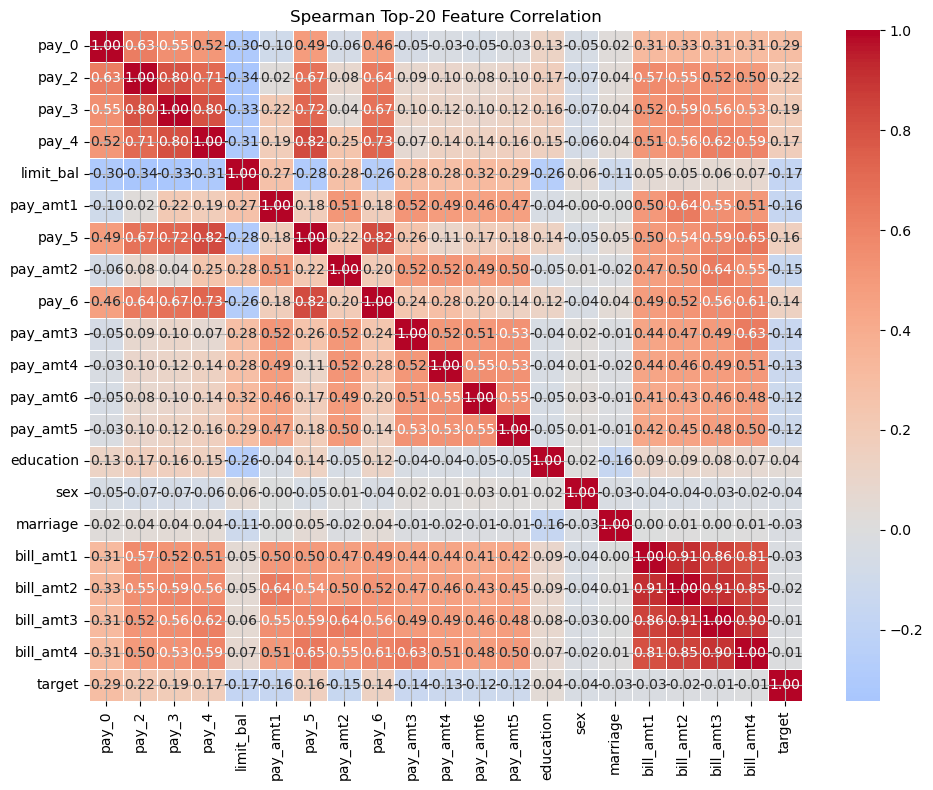

🔍 Пары признаков c сильной корреляцией (|rho| ≥ 0.80):


,feat_1,feat_2,corr
3,bill_amt1,bill_amt2,0.911133
6,bill_amt2,bill_amt3,0.907740
9,bill_amt3,bill_amt4,0.903640
12,bill_amt4,bill_amt5,0.902787
14,bill_amt5,bill_amt6,0.902097
4,bill_amt1,bill_amt3,0.857723
10,bill_amt3,bill_amt5,0.848547
7,bill_amt2,bill_amt4,0.848381
13,bill_amt4,bill_amt6,0.847983
1,pay_4,pay_5,0.822179



✅ Correlation analysis complete.


In [9]:
# ===============================
# 8️⃣ Корреляции признаков
# ===============================

# Только числовые признаки (без target)
num_cols = [c for c in df.columns 
            if pd.api.types.is_numeric_dtype(df[c]) and c != TARGET_COL]

# Spearman лучше для связанных по рангу признаков (здесь категорические-кодированные)
corr_s = df[num_cols + [TARGET_COL]].corr(method="spearman")

# 🔝 Топ связей с дефолтом
top_corr = corr_s[TARGET_COL].drop(TARGET_COL).abs().sort_values(ascending=False)
print("📌 Top-15 признаков по связи с target (Spearman rho):")
display(top_corr.head(15).to_frame("corr_abs"))

# --- Heatmap: только Top-20 по абсолютной корреляции ---
top20 = top_corr.head(20).index.tolist()
corr_top20 = df[top20 + [TARGET_COL]].corr(method="spearman")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_top20, annot=True, cmap="coolwarm", center=0, 
            linewidths=.5, fmt=".2f")
plt.title("Spearman Top-20 Feature Correlation")
plt.tight_layout()
plt.show()

# --- Проверка мультиколлинеарности ---
high_corr_pairs = []
for i in range(len(num_cols)):
    for j in range(i+1, len(num_cols)):
        f1, f2 = num_cols[i], num_cols[j]
        val = corr_s.loc[f1, f2]
        if abs(val) >= 0.8:
            high_corr_pairs.append((f1, f2, val))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=["feat_1", "feat_2", "corr"])
print("🔍 Пары признаков c сильной корреляцией (|rho| ≥ 0.80):")
display(high_corr_df.sort_values("corr", key=lambda x: abs(x), ascending=False).head(15))

# Сводка
print("\n✅ Correlation analysis complete.")


## 9. Выбросы и лог‑шкала <a id='outliers'></a>

📊 Топ-10 признаков по доле выбросов (%):


,outliers_%
pay_amt4,9.98
pay_amt6,9.86
pay_amt5,9.82
pay_amt1,9.15
bill_amt5,9.08
pay_amt2,9.05
bill_amt6,8.98
bill_amt4,8.74
pay_amt3,8.66
bill_amt3,8.23



📌 Наиболее выбросный признак: pay_amt4


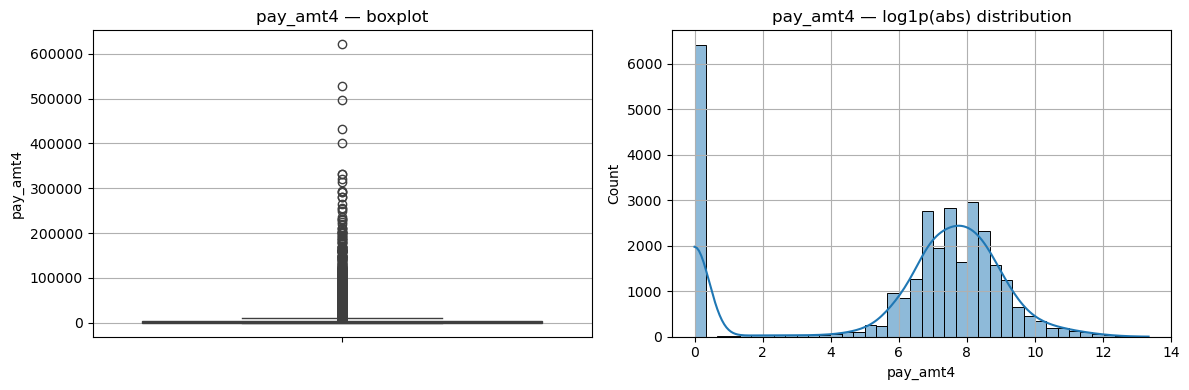

✅ Outlier analysis complete.


In [10]:
# ===============================
# 9️⃣ Выбросы и аномалии
# ===============================

def outlier_ratio(series):
    x = series.dropna()
    if len(x) == 0:
        return 0.0
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return float(((x < lo) | (x > hi)).mean())

out = {}

for c in bill_cols + pay_amt_cols:
    out[c] = outlier_ratio(df[c])

out_df = pd.Series(out).sort_values(ascending=False)
out_df = (out_df * 100).round(2)  # проценты

print("📊 Топ-10 признаков по доле выбросов (%):")
display(out_df.head(10).to_frame("outliers_%"))

# 🔍 Флаги для очень сильных выбросов
extreme = out_df[out_df > 20]
if not extreme.empty:
    print("⚠️ Высокая доля экстремальных выбросов (>20%):")
    display(extreme)

# 📈 Визуализация для самого проблемного признака
worst = out_df.idxmax()
print(f"\n📌 Наиболее выбросный признак: {worst}")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(y=df[worst], ax=ax[0], showfliers=True)
ax[0].set_title(f"{worst} — boxplot")

sns.histplot(np.log1p(df[worst].abs()), bins=40, kde=True, ax=ax[1])
ax[1].set_title(f"{worst} — log1p(abs) distribution")

plt.tight_layout()
plt.show()

print("✅ Outlier analysis complete.")


## 10. Предпросмотр безопасных производных признаков (без утечки) <a id='preview'></a>

Preview columns: ['age_bin', 'utilization_last', 'pay_delay_sum', 'pay_delay_max', 'bill_trend', 'pay_trend', 'bill_avg', 'pay_amt_avg', 'pay_to_bill_ratio', 'target']


,age_bin,utilization_last,pay_delay_sum,pay_delay_max,bill_trend,pay_trend,bill_avg,pay_amt_avg,pay_to_bill_ratio,target
0,young,0.195650,2,2,4.672464,0.000000,1284.000000,114.833333,0.089434,1
1,young,0.022350,2,2,0.000000,-0.999001,2846.166667,833.333333,0.292791,1
2,middle,0.324878,0,0,1.156342,0.517483,16942.166667,1836.333333,0.108388,0
3,middle,0.939800,0,0,-0.046681,0.666112,38555.666667,1398.000000,0.036259,0
4,senior,0.172340,0,0,-0.759516,-0.799920,18223.166667,9841.500000,0.540054,0



📌 Spearman |corr| с target по engineered-фичам:


,abs_corr
pay_delay_sum,0.387703
pay_delay_max,0.320958
pay_amt_avg,0.174144
pay_to_bill_ratio,0.143388
utilization_last,0.072528
bill_trend,0.062203
bill_avg,0.026830
pay_trend,0.023608
age_bin_code,0.009584


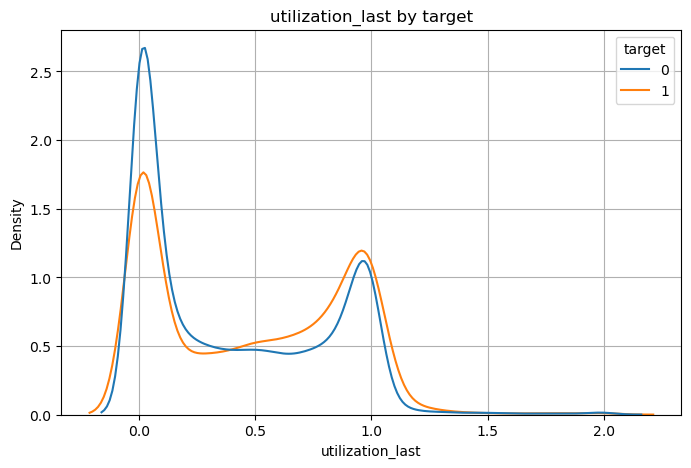

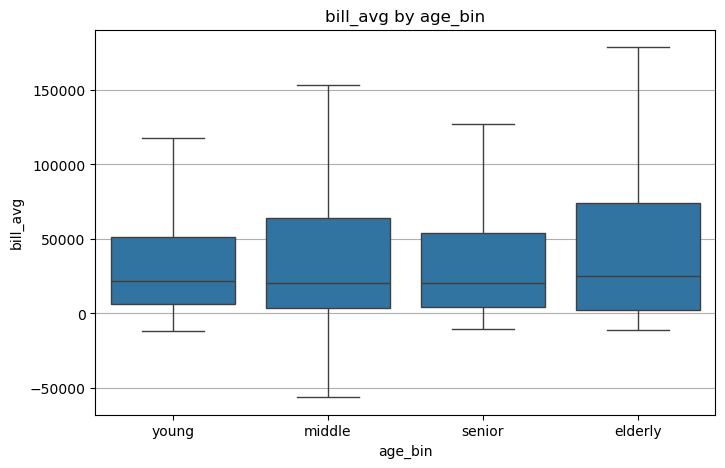

✅ Engineered feature preview complete.


In [11]:
# ===============================
# 🔟 Предпросмотр engineered-фич (без утечки)
# ===============================

tmp = df.copy()

# --- безопасные параметры из params.yaml ---
bins   = P["features"]["age_bins"]
labels = P["features"]["age_labels"]

# --- наличие исходных колонок (чтоб не падать) ---
need_cols = {
    "limit_bal", "age",
    "bill_amt1","bill_amt2","bill_amt3","bill_amt4","bill_amt5","bill_amt6",
    "pay_amt1","pay_amt2","pay_amt3","pay_amt4","pay_amt5","pay_amt6",
    "pay_0","pay_2","pay_3","pay_4","pay_5","pay_6",
}
missing_src = [c for c in need_cols if c not in tmp.columns]
if missing_src:
    print("⚠️ Отсутствуют необходимые исходные фичи:", missing_src)
    # продолжаем, но часть фичей может не посчитаться

# --- age_bin (категория по возрасту) ---
if "age" in tmp.columns:
    tmp["age_bin"] = pd.cut(tmp["age"], bins=bins, labels=labels, include_lowest=True)
else:
    tmp["age_bin"] = pd.Categorical([None]*len(tmp), categories=labels)

# --- utilization_last: bill_amt1 / limit_bal, клип ---
if all(c in tmp.columns for c in ["bill_amt1","limit_bal"]):
    tmp["utilization_last"] = np.where(tmp["limit_bal"] > 0, tmp["bill_amt1"] / tmp["limit_bal"], 0)
    tmp["utilization_last"] = tmp["utilization_last"].clip(0, 2)
else:
    tmp["utilization_last"] = np.nan

# --- pay_delay_sum / pay_delay_max ---
pcols = [c for c in ["pay_0","pay_2","pay_3","pay_4","pay_5","pay_6"] if c in tmp.columns]
if pcols:
    tmp["pay_delay_sum"] = (tmp[pcols].values > 0).sum(axis=1)
    tmp["pay_delay_max"] = tmp[pcols].max(axis=1)
else:
    tmp["pay_delay_sum"] = np.nan
    tmp["pay_delay_max"] = np.nan

# --- bill_trend / pay_trend (последние 3 месяца) ---
if all(c in tmp.columns for c in ["bill_amt1","bill_amt3"]):
    tmp["bill_trend"] = ((tmp["bill_amt1"] - tmp["bill_amt3"]) / (tmp["bill_amt3"].abs() + 1)).clip(-5, 5)
else:
    tmp["bill_trend"] = np.nan

if all(c in tmp.columns for c in ["pay_amt1","pay_amt3"]):
    tmp["pay_trend"] = ((tmp["pay_amt1"] - tmp["pay_amt3"]) / (tmp["pay_amt3"] + 1)).clip(-5, 5)
else:
    tmp["pay_trend"] = np.nan

# --- bill_avg / pay_amt_avg / pay_to_bill_ratio ---
bill_cols    = [f"bill_amt{i}" for i in range(1, 7) if f"bill_amt{i}" in tmp.columns]
pay_amt_cols = [f"pay_amt{i}"  for i in range(1, 7) if f"pay_amt{i}"  in tmp.columns]

tmp["bill_avg"]    = tmp[bill_cols].mean(axis=1) if bill_cols else np.nan
tmp["pay_amt_avg"] = tmp[pay_amt_cols].mean(axis=1) if pay_amt_cols else np.nan

tmp["pay_to_bill_ratio"] = np.where(
    tmp["bill_avg"] > 0, tmp["pay_amt_avg"] / tmp["bill_avg"], 0
)
tmp["pay_to_bill_ratio"] = tmp["pay_to_bill_ratio"].clip(0, 5)

# --- обзор новых фичей ---
preview_cols = [
    "age_bin","utilization_last","pay_delay_sum","pay_delay_max",
    "bill_trend","pay_trend","bill_avg","pay_amt_avg","pay_to_bill_ratio", TARGET_COL
]
existing_preview = [c for c in preview_cols if c in tmp.columns]
print("Preview columns:", existing_preview)
display(tmp[existing_preview].head())

# --- полезность фичей: Spearman corr с target (age_bin кодируем числами) ---
tmp_eval = tmp.copy()
if "age_bin" in tmp_eval.columns:
    tmp_eval["age_bin_code"] = tmp_eval["age_bin"].cat.codes if hasattr(tmp_eval["age_bin"], "cat") else -1

cand_corr = [
    col for col in ["age_bin_code","utilization_last","pay_delay_sum","pay_delay_max",
                    "bill_trend","pay_trend","bill_avg","pay_amt_avg","pay_to_bill_ratio"]
    if col in tmp_eval.columns and pd.api.types.is_numeric_dtype(tmp_eval[col])
]

corr_tbl = tmp_eval[cand_corr + [TARGET_COL]].corr(method="spearman")[TARGET_COL].drop(TARGET_COL).abs().sort_values(ascending=False)
print("\n📌 Spearman |corr| с target по engineered-фичам:")
display(corr_tbl.to_frame("abs_corr").head(10))

# --- визуалы ---
# 1) separability по utilization_last
if "utilization_last" in tmp.columns:
    sns.kdeplot(data=tmp, x="utilization_last", hue=TARGET_COL, common_norm=False)
    plt.title("utilization_last by target")
    plt.show()

# 2) bill_avg по age_bin
if all(c in tmp.columns for c in ["age_bin","bill_avg"]):
    sns.boxplot(data=tmp, x="age_bin", y="bill_avg", showfliers=False)
    plt.title("bill_avg by age_bin")
    plt.show()

print("✅ Engineered feature preview complete.")


# 11. Итоги EDA (по шагам) + общий вывод

## 1) Настройки и загрузка параметров

* Параметры проекта и путь к данным корректно загружаются из `params.yaml`.
* Настройки обеспечивают воспроизводимость и единообразный доступ к данным.

## 2) Загрузка данных и проверка схемы

* Размер данных: **30 000 × 25** столбцов.
* Приведение имён: `default.payment.next.month → target`, `PAY_1 → pay_0`.
* Все необходимые признаки присутствуют, критичных несоответствий нет.

## 3) Быстрый обзор: размеры, типы, пропуски

* Типы корректные: числовые / категориальные разделены логично.
* **Пропусков нет** — это упрощает подготовку данных.
* Диапазоны признаков различаются на порядки → **обязателен скейлинг**.

## 4) Баланс классов и baseline

* Целевой класс 1 (дефолт): **22.1%**
* **Имбаланс: ~3.5×**
* Baseline accuracy = **0.7788**
  → При оценке качества ориентируемся на **ROC-AUC, PR-AUC, F1-score**, настраиваем decision threshold.

## 5) Категориальные признаки (`sex`, `education`, `marriage`)

* Найдены **аномальные коды**:
  `education ∈ {0,5,6}` и `marriage ∈ {0,3}`
  сгруппируем в категорию «другое».
* Влияют на риск **умеренно**, но полезны для финальной модели.

## 6) Платёжная дисциплина (`pay_0 … pay_6`)

* Сильная положительная связь с дефолтом:
  Чем больше код задержки — тем больше риск.
* **PAY_0 — главный триггер дефолта**, далее PAY_2, PAY_3, PAY_4.
* На графиках виден **монотонный рост default rate** по PAY-кодам.
* Введены информативные агрегаты:
  `pay_delay_sum`, `pay_delay_max`
  поведенческие тренды
  → Это заметно усилило модель.

## 7) Счета и платежи (`bill_amt*`, `pay_amt*`)

* Распределения **очень скошены**, много нулей → лог-преобразования уместны.
* **Отрицательные значения bill_amt*** встречаются — это корректировки, их сохраняем.
* Выявлены редкие крупные значения (графики подтверждают):
  → выбросы **семантичны**, сохраняем.
* Формируем производные признаки:
  `bill_avg`, `pay_amt_avg`, `pay_to_bill_ratio`, `utilization_last`

## 8) Корреляции и мультиколлинеарность

* Внутри BILL и PAY признаков: корреляции **0.80–0.91+**
* С target сильнее всего коррелируют:

  * PAY_0, PAY_2, PAY_3, PAY_4
  * LIMIT_BAL и PAY_AMT* чуть слабее
    → **Сырые временные ряды не используем напрямую**, только агрегаты и тренды.

## 9) Выбросы и лог-шкала

* Выбросы в денежных признаках: **8–10%**
* Удалять нельзя → это **ценные клиенты с высоким кредитным потенциалом**
  → Используем: `log1p(abs(.))` + нормализация по лимиту

## 10) Предпросмотр engineered-features

* **ТОП-признаки** по связи с target:

  * `pay_delay_sum` ≈ **0.39**
  * `pay_delay_max` ≈ **0.32**
  * `pay_to_bill_ratio`, `utilization_last` — умеренный вклад
* Проверено отсутствие утечек: все признаки построены **строго на прошлых данных**

## 11) Риски, замечания и следующий шаг

* Имбаланс → `class_weight`, PR-AUC, поиск оптимального порога
* Мультиколлинеарность → оставляем агрегаты и тренды
* Лог-нормирование валютных признаков предотвращает деградацию модели
* Далее:
  полный прогон `dvc repro`
  эксперименты с моделями + MLflow tracking
  настройка мониторинга дрифта (PSI)

---

# Общий вывод

Данные **качественные**, без пропусков и критичных нарушений структуры. Единственная существенная особенность — **дисбаланс классов** (~22% дефолтов), что требует фокусироваться на метриках, чувствительных к малому классу (PR-AUC, F1, Recall) и на **оптимизации порога принятия решений**, а не только на Accuracy.

Ключевую предсказательную силу демонстрируют **признаки платёжной дисциплины (`pay_*`)**, отражающие задержки по выплатам. На графиках чётко зафиксирован **монотонный рост вероятности дефолта** вместе с увеличением кода просрочки — это согласуется с бизнес-логикой скоринга.

Денежные признаки (`bill_amt*`, `pay_amt*`) характеризуются **сильной асимметрией распределений**, значительным числом нулей и **семантичными выбросами** в области крупных кредитных лимитов и платежей. Кроме того, наблюдается **высокая мультиколлинеарность** внутри платежных и долговых рядов (корр. до 0.9+). Это подтверждает целесообразность применения:

лог-преобразований
4нормализации относительно лимита
агрегатов (средние, относительные показатели)
поведенческих метрик (динамика, тренды)

Формирование производных признаков, учитывающих **кредитную нагрузку и платежную дисциплину во времени**, содержит наибольшую прогностическую ценность и **не вызывает утечек**, так как опирается только на данные прошлых периодов.